## Environment setup

First it is mandatory to load our environment file, which holds our dataset file path.

In [75]:
from dotenv import load_dotenv
import os
load_dotenv()
dataset_path = os.getenv('TASK_DATASET_FILE_PATH')


We then import all the needed libraries, including our produced scripts:

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from src.cache import cached
from src.preprocess import interesting_columns

## Preprocessing
We use `chached` from `src.cache`  to load our data, it's a commodity functions which loads or creates then caches a dataframe, saving us much needed time in loading our dataset.  
It produces a `CachedDataFrame` resource, which can be further used to manipulate these cache files.  
For our dataset, we need only the data frame, thus we just `get` it, and print some information.

In [77]:
df = cached(
    dataset_path + '.picke',
    construct = lambda : pd.read_csv(dataset_path, usecols=interesting_columns.keys()).dropna().astype(interesting_columns)
).get()
df.info( verbose=True )

<class 'pandas.core.frame.DataFrame'>
Index: 2331562 entries, 0 to 2331567
Data columns (total 12 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   scontrino_id  int64 
 1   tessera       int64 
 2   cod_prod      int64 
 3   descr_prod    object
 4   liv1          int64 
 5   descr_liv1    object
 6   liv2          int64 
 7   descr_liv2    object
 8   liv3          int64 
 9   descr_liv3    object
 10  liv4          int64 
 11  descr_liv4    object
dtypes: int64(7), object(5)
memory usage: 231.2+ MB


We can clearly see that at least **200+ MB** have been allocated.  

The assigned tasks requires us to produce the cross table between customers and products, to further compute clusterization.  
We can compute the amount of memory used by the cross table, using `int64` as cell type:

In [78]:
number_of_cells = df['cod_prod'].nunique() * df['tessera'].nunique()
entry_size = np.int64().itemsize
print(f"The number of entries is {number_of_cells} and it requires {number_of_cells * entry_size *1e-6 :0.2f} MiB of space.")

The number of entries is 182213184 and it requires 1457.71 MiB of space.


Further considerations on the tasks are:
- Many products are bought rarely, these introduce outliers.
- Some products are too common, these would produce trivial and uninteresting results.
- Many users shops rarely, these too will introduce outliers.

We have to analyze better our dataset, then prune these unwanted features.

### Products pruning
We can plot the frequencies of products, using a logarithmic function as the orders of them vastly differ.  
The logarithmic function clearly shows where products get rarely bought, I decided to take the items with frequencies between **$10^{-3}$** and **$10^{-5}$**.

<Figure size 800x600 with 0 Axes>

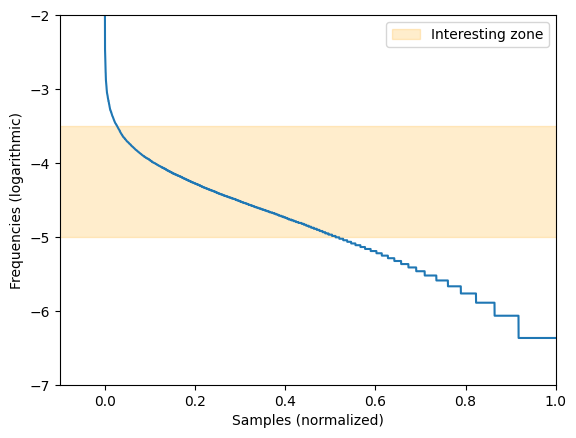

Selected 48% of products. (9412 of 19434)


In [82]:
freqs_ss = df['cod_prod'].value_counts(normalize=True)

pir = (-3.5, -5)
 
plt.figure(figsize=(8,6))

fig, ax = plt.subplots()


plt.plot( np.linspace(0,1,freqs_ss.size) ,np.log10(freqs_ss.values))

rect = patches.Rectangle(
    (-1, pir[1]), np.abs(pir[0]), 
    np.abs(pir[1]-pir[0]), 
    color='orange', alpha=0.2, label="Interesting zone"
)
plt.ylabel("Frequencies (logarithmic)")
plt.xlabel("Samples (normalized)")

plt.xlim(-.1, 1)
plt.ylim(-7, -2)
ax.add_patch(rect)
plt.legend()
plt.show()

products_ss = freqs_ss[(freqs_ss < 10**pir[0]) & (freqs_ss > 10**pir[1])]
print(f"Selected {products_ss.size/df['cod_prod'].nunique():1.0%} of products. ({products_ss.size} of {df['cod_prod'].nunique()})")

### Customers pruning
As done for products, customer frequencies in logarithmic scale are plotted as follow, I arbitrary choose a minimum support of **10**, those customers with less than **10** purchases will be marked as outliers.

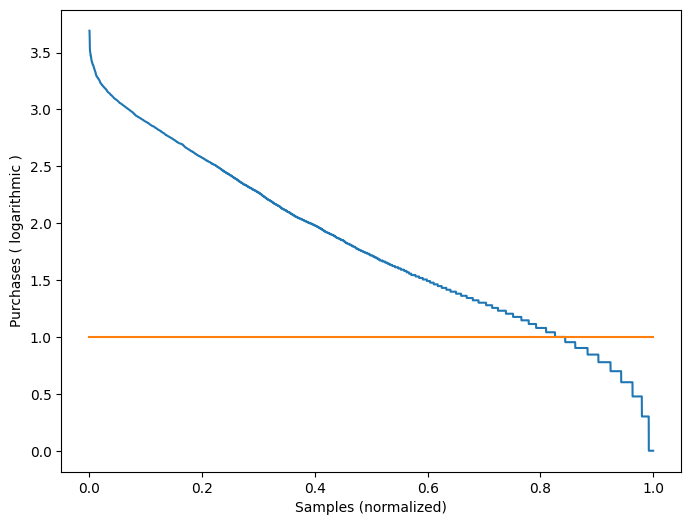

Selected 84% of customers. (7913 of 9376) 


In [81]:

freqs_ss = df['tessera'].value_counts(normalize=False)


plt.figure(figsize=(8,6))

plt.plot( np.linspace(0,1,freqs_ss.size) ,np.log10(freqs_ss.values))

plt.plot([0,1],[1,1])
plt.ylabel("Purchases ( logarithmic )")
plt.xlabel("Samples (normalized)")

plt.show()

customers_ss = freqs_ss[ (freqs_ss >= 10)]
print(f"Selected {customers_ss.size/df['tessera'].nunique():1.0%} of customers. ({customers_ss.size} of {df['tessera'].nunique()}) ")

The memory footprint of our cross table is:

In [84]:
number_of_cells = customers_ss.size * products_ss.size
entry_size = np.int64().itemsize
print(f"The number of entries is {number_of_cells} and it requires {number_of_cells * entry_size *1e-6 :0.2f} MiB of space.")

The number of entries is 74477156 and it requires 595.82 MiB of space.
